In [1]:
from pathlib import Path
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import aggregate_downsample
from astropy.timeseries import TimeSeries

import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def boundify(a, sigma=2.0):
    mean = a.mean()
    dev = np.std(a)
    
    return (mean - (sigma * dev)).value, (mean + (sigma * dev)).value

def check_filter(labels):
    values = []
    
    for label in labels:
        if re.match(r'.*_B[0-9]+_.*', str(label)):
            values.append('Blue')
        elif re.match(r'.*_V[0-9]+_.*', str(label)):
            values.append('Green')
        elif re.match(r'.*_R[0-9]+_.*', str(label)):
            values.append('Red')
        else:
            values.append('Unknown')
    
    return values


In [4]:
# constants
working_directory = Path('/data/PIRATE/FITS/')
csv_data = working_directory / 'CRTS J092751.8-040759.csv'

# TODO: automatically infer this from the FITS data
period = 8.6447215 * u.hour

plt.style.use('guide.mplstyle')

In [8]:
t = Table.read(csv_data, format='ascii.csv', delimiter='\t', fast_reader=False)
# curate columns
t['JD_UTC'].unit = u.day
t['time'] = Time(t['JD_UTC'], format='jd')
t['filter'] = check_filter(t['Label'])

for row in t:
    check_filter(row)

# remove unwanted data
t.keep_columns(['time','rel_flux_T1', 'rel_flux_err_T1', 'filter'])
t['rel_flux_T1'].unit = 'mag'

In [9]:
ts = TimeSeries(t)
t

rel_flux_T1,rel_flux_err_T1,time,filter
mag,,,
float64,float64,object,str5
0.00856,4.8e-05,2458542.398672,Blue
0.008859,4.9e-05,2458542.402587,Blue
0.009069,5e-05,2458542.406519,Blue
0.009064,5e-05,2458542.410444,Blue
0.008671,4.7e-05,2458542.414341,Blue
0.008538,4.5e-05,2458542.418275,Blue
0.008571,4.6e-05,2458542.42223,Blue
0.009409,5e-05,2458542.426152,Blue


In [10]:
ts_folded = ts.fold(period=period, normalize_phase=True, wrap_phase=1.0)
ts_folded.sort('time')

period.to(u.hour)

<Quantity 8.6447215 h>

Text(0, 0.5, 'SAP Flux (e-/s)')

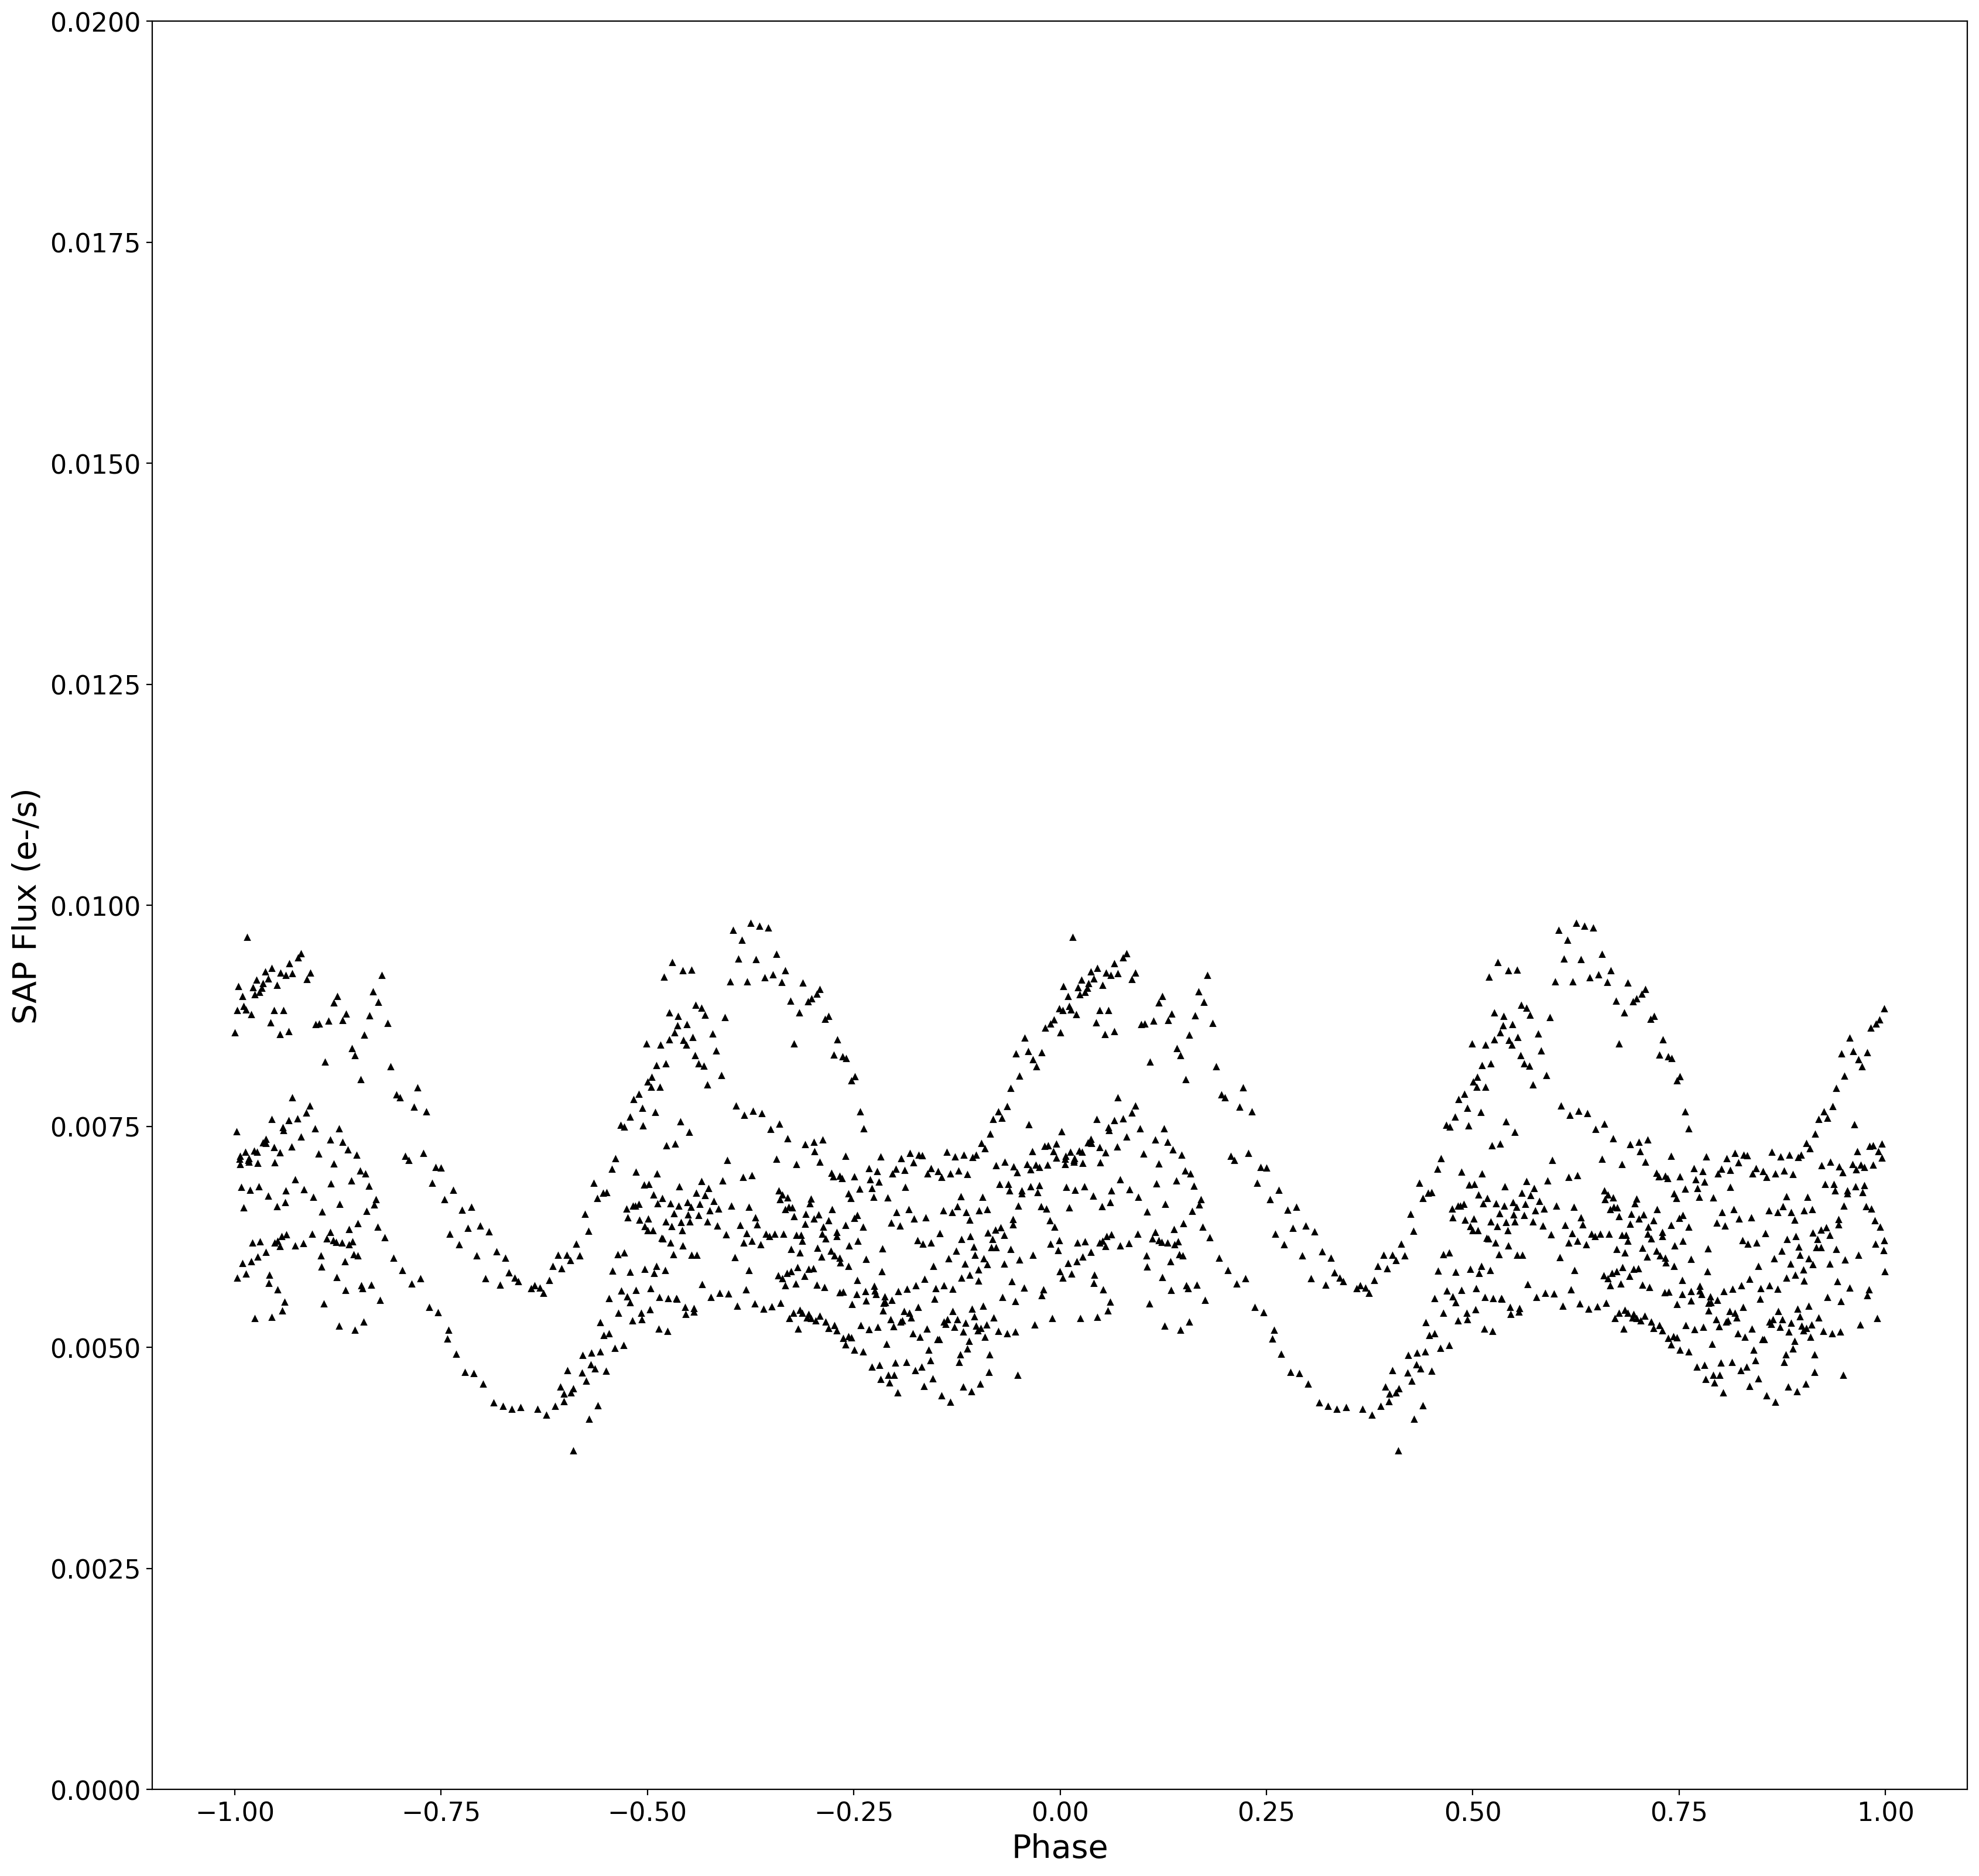

In [11]:
y_min, y_max = boundify(ts_folded['rel_flux_T1'])
y_min = 0.00
y_max = 0.02
marker='^'
markersize=3
linestyle=''


plt.figure(figsize=(20,20))
plt.plot(ts_folded.time, ts_folded['rel_flux_T1'], 'k.', markersize=markersize, marker=marker, linestyle=linestyle)
plt.plot(ts_folded.time - 1.0, ts_folded['rel_flux_T1'], 'k.', markersize=markersize, marker=marker, linestyle=linestyle)
plt.ylim(bottom=y_min, top=y_max)
plt.xlabel('Phase')
plt.ylabel('SAP Flux (e-/s)')

In [12]:
# seperate the colour channels
ts_red = ts_folded[ts_folded['filter'] == 'Red']
ts_green = ts_folded[ts_folded['filter'] == 'Green']
ts_blue = ts_folded[ts_folded['filter'] == 'Blue']

/usr/lib/python3/dist-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


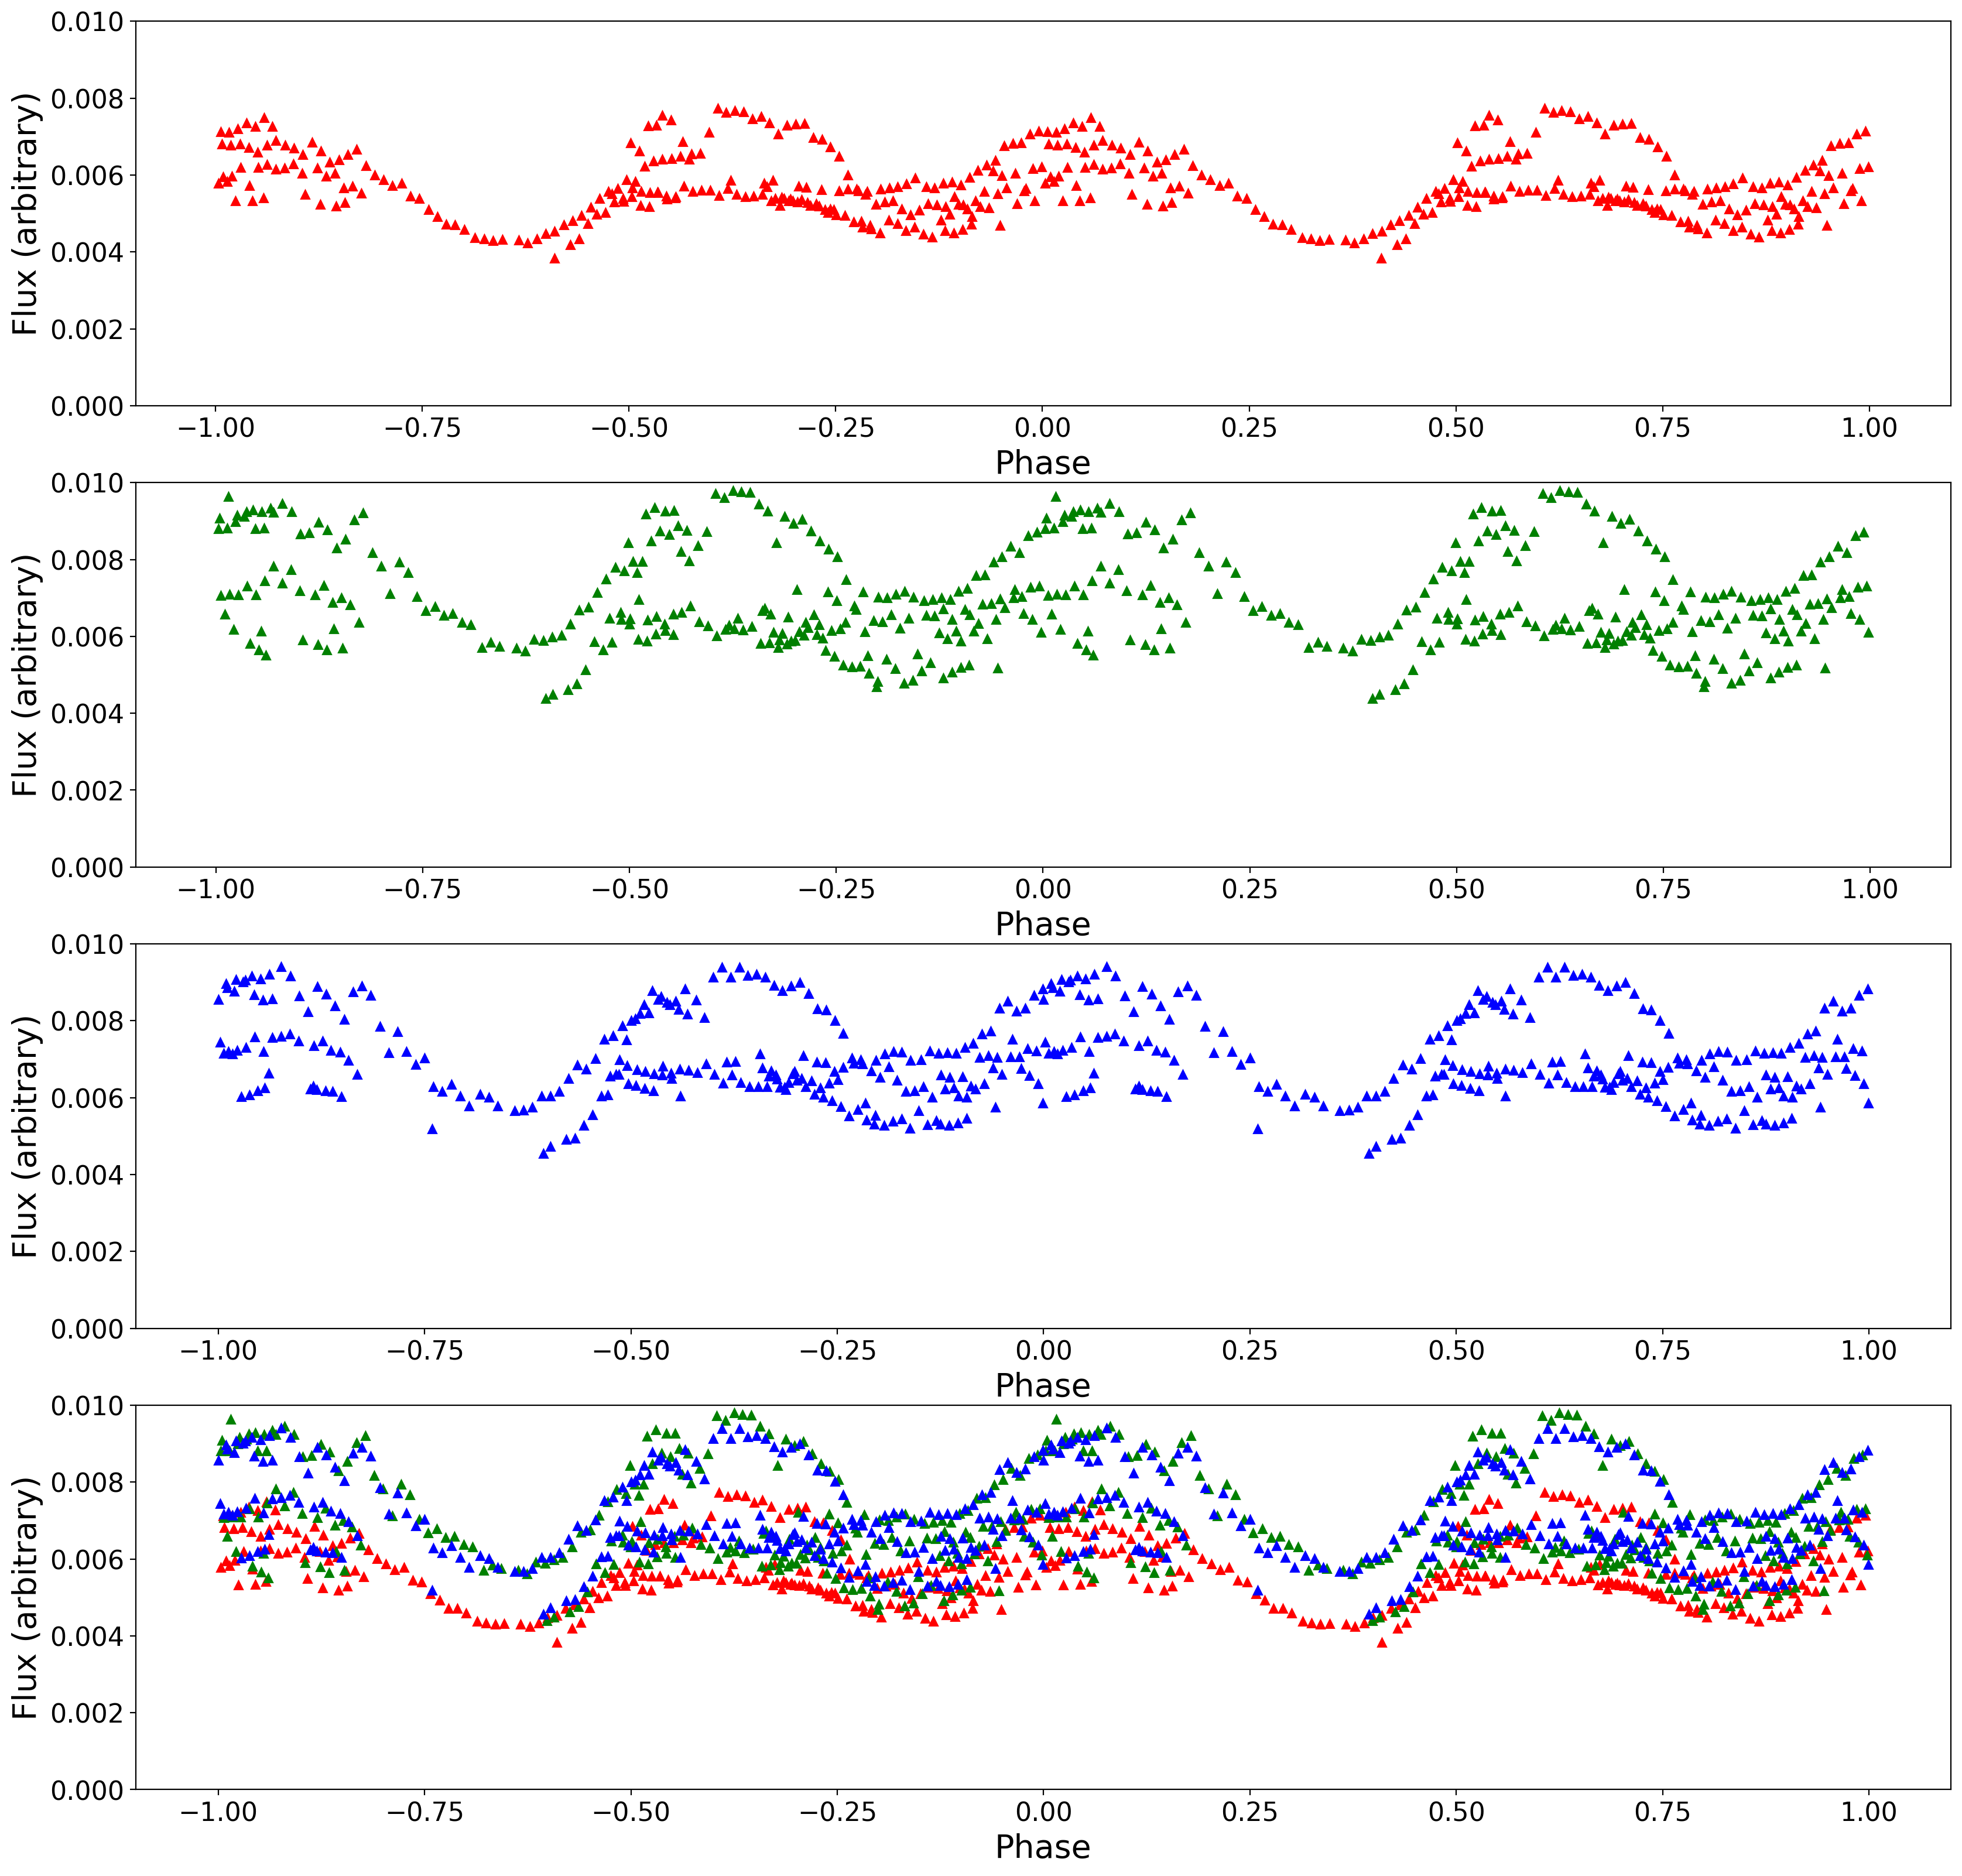

In [14]:
y_min, y_max = boundify(ts_folded['rel_flux_T1'], sigma=0)
y_min = 0.00
y_max = 0.01

fig = plt.figure(figsize=(20,20))

markersize = 5
markerstyle = '^'
linestyle = ''
xlabel = 'Phase'
ylabel = 'Flux (arbitrary)'

ax1 = fig.add_subplot(411)
#ax1.errorbar(ts_red.time, ts_red['rel_flux_T1'].value, yerr=ts_red['rel_flux_err_T1'], fmt='r.', markersize=1, linestyle=':')
#ax1.errorbar(ts_red.time - 1.0, ts_red['rel_flux_T1'].value, yerr=ts_red['rel_flux_err_T1'], fmt='r.', markersize=1, linestyle=':')
ax1.plot(ts_red.time, ts_red['rel_flux_T1'].value, 'r.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax1.plot(ts_red.time - 1.0, ts_red['rel_flux_T1'].value, 'r.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax1.set_ylim(y_min, y_max)
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)

ax2 = fig.add_subplot(412)
#ax2.errorbar(ts_green.time, ts_green['rel_flux_T1'].value, yerr=ts_green['rel_flux_err_T1'], fmt='g.', markersize=1, linestyle=':')
#ax2.errorbar(ts_green.time - 1.0, ts_green['rel_flux_T1'].value, yerr=ts_green['rel_flux_err_T1'], fmt='g.', markersize=1, linestyle=':')
ax2.plot(ts_green.time, ts_green['rel_flux_T1'].value, 'g.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax2.plot(ts_green.time - 1.0, ts_green['rel_flux_T1'].value, 'g.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax2.set_ylim(y_min, y_max)
ax2.set_xlabel(xlabel)
ax2.set_ylabel(ylabel)

ax3 = fig.add_subplot(413)
#ax3.errorbar(ts_blue.time, ts_blue['rel_flux_T1'].value, yerr=ts_blue['rel_flux_err_T1'], fmt='b.', markersize=1, linestyle=':')
#ax3.errorbar(ts_blue.time - 1.0, ts_blue['rel_flux_T1'].value, yerr=ts_blue['rel_flux_err_T1'], fmt='b.', markersize=1, linestyle=':')
ax3.plot(ts_blue.time, ts_blue['rel_flux_T1'].value, 'b.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax3.plot(ts_blue.time - 1.0, ts_blue['rel_flux_T1'].value, 'b.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax3.set_ylim(y_min, y_max)
ax3.set_xlabel(xlabel)
ax3.set_ylabel(ylabel)

ax4 = fig.add_subplot(414)
#ax3.errorbar(ts_blue.time, ts_blue['rel_flux_T1'].value, yerr=ts_blue['rel_flux_err_T1'], fmt='b.', markersize=1, linestyle=':')
#ax3.errorbar(ts_blue.time - 1.0, ts_blue['rel_flux_T1'].value, yerr=ts_blue['rel_flux_err_T1'], fmt='b.', markersize=1, linestyle=':')
ax4.plot(ts_red.time, ts_red['rel_flux_T1'].value, 'r.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax4.plot(ts_red.time - 1.0, ts_red['rel_flux_T1'].value, 'r.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax4.plot(ts_green.time, ts_green['rel_flux_T1'].value, 'g.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax4.plot(ts_green.time - 1.0, ts_green['rel_flux_T1'].value, 'g.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax4.plot(ts_blue.time, ts_blue['rel_flux_T1'].value, 'b.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax4.plot(ts_blue.time - 1.0, ts_blue['rel_flux_T1'].value, 'b.', markersize=markersize, marker=markerstyle, linestyle=linestyle)
ax4.set_ylim(y_min, y_max)
ax4.set_xlabel(xlabel)
ax4.set_ylabel(ylabel)


fig.show()

In [15]:
fig.savefig(csv_data.with_suffix('.png'), format='png')